In [1]:
import os
import numpy as np
import pandas as pd
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)

seaborn.set_theme(style="darkgrid")
db_url = os.getenv('DB_URL')

In [2]:
sql = """
select
    p.program_number,
    p.program_name,
    p.address_zip_code AS program_zip_code,
    p.borough_district_code AS program_borough_district_code,
    p.borough_district_code in (109, 110, 111) As is_program_in_harlem,
    patients.patient_zip_code,
    case 
        when patients.patient_zip_code in ('10026', '10027', '10037', '10030', '10039', '10031', '10035') then 'In Harlem'
        when patients.patient_zip_code in ('10032', '10025', '10029') then 'Near Harlem'
        else 'Not In Harlem'
    end as patient_near_harlem,
    patients.total_admissions,
    is_redacted,
    coalesce(patients.total_admissions, 1) as admissions_1,
    coalesce(patients.total_admissions, 3) as admissions_3,
    coalesce(patients.total_admissions, 5) as admissions_5
from program_admissions_2019 as patients
    left join programs as p using (program_number)
where patients.program_service_type = 'Opioid Treatment'
"""
admissions = pd.read_sql(sql, con=db_url)
for c in [
    'program_number',
    'program_zip_code',
    'program_borough_district_code',
    'patient_zip_code'
]:
    admissions[c] = pd.Categorical(admissions[c])
print(admissions.shape)
admissions.head(1)

(3098, 12)


,program_number,program_name,program_zip_code,program_borough_district_code,is_program_in_harlem,patient_zip_code,patient_near_harlem,total_admissions,is_redacted,admissions_1,admissions_3,admissions_5
0,1183,"PROMESA, Inc. MTA-R",10457,205,False,11208,Not In Harlem,NaN,True,1,3,5


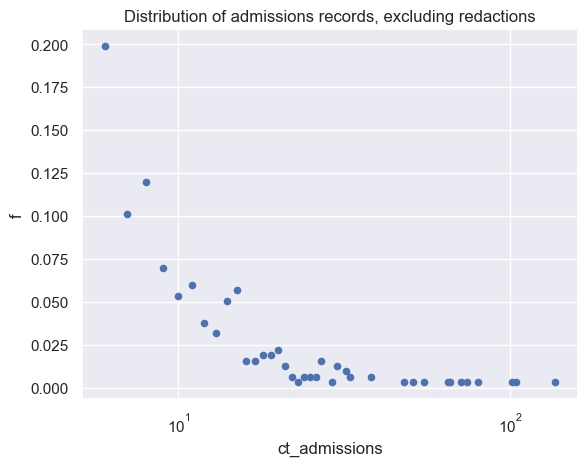

In [3]:
admission_cts = (admissions.total_admissions
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'ct_admissions','total_admissions': 'ct_records'})
)
admission_cts['log_a'] = np.log(admission_cts['ct_admissions'])
admission_cts['f'] = admission_cts['ct_records'] / admission_cts['ct_records'].sum()
ax = admission_cts.plot(kind='scatter', x='ct_admissions', y='f', logx=True)
ax.set_title("Distribution of admissions records, excluding redactions");



## Estimate redactions

The total admissions data, while sparse, has a pretty clear distribution. We can infer that the redactions fall into that
to come up with a naive estimate of their frequencies. Most are 1s.

(It would help a lot to have some data on something like total patients per clinic, clinic capacity, or total patients per resident zip code.)

But failing at that, we can do even better by assuming that *clinic* attendance follows a neat distribution (TBD what), and that patients-per-zip follows a neat distribution, and jointly learn all of these.

(Actually, its patients-per-observed zip; we assume that zips with less access to clinics are less represented. Zip-zip travel time would be helpful.)


### Step 1: learn a naive distribution of redactions given nothing else except admission frequencies.

Let $a$ be the number of admissions observed from a zip code to a given clinic, with no aggregation (i.e. what was plotted just above).

Let's model the following:

$$
P(a) \propto \left\{
\begin{array}{ll}
      a>5 & f(a) \\
      a \leq 5 & 0
\end{array} 
\right.
$$


First, a model that includes all the NA values.

In [3]:
import pymc
import arviz
arviz.style.use("arviz-darkgrid")

a_obs = admissions.total_admissions.fillna(5)

a_model = pymc.Model()
with a_model:
    p = pymc.Uniform('p', lower=0, upper=1)
    # n = pymc.LogNormal('n', mu=0, sigma=1)
    # alpha = pymc.LogNormal('alpha', mu=1, sigma=1)
    # mu = pymc.LogNormal('mu', mu=1, sigma=1)
    # o = pymc.Censored('o', dist=pymc.Poisson.dist(mu=mu), lower=5, upper=None, observed=a_obs)
    # o = pymc.Censored('o', dist=pymc.NegativeBinomial.dist(alpha=alpha, mu=mu), lower=5, upper=None, observed=a_obs)
    o = pymc.Censored('o', dist=pymc.Geometric.dist(p=p), lower=5, upper=None, observed=a_obs)
    idata = pymc.sample(2000)
    pr = pymc.sample_prior_predictive()
    pp = pymc.sample_posterior_predictive(idata)


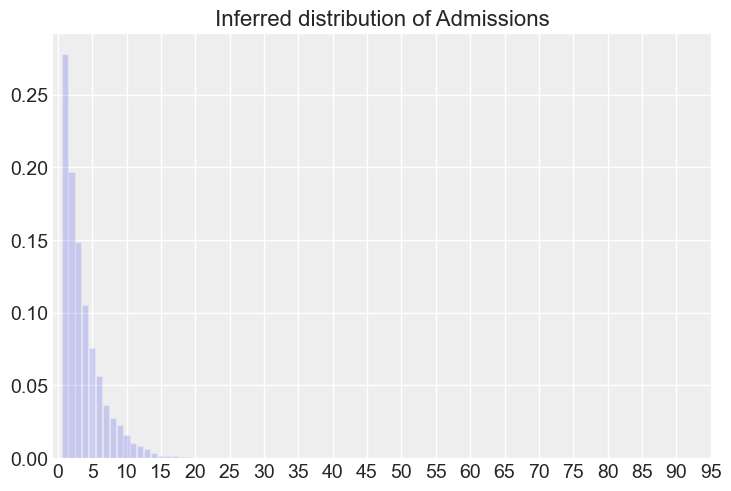

In [8]:
# arviz.plot_trace(idata)
# arviz.plot_dist(idata['posterior']['p'])
# arviz.plot_dist(pr['prior_predictive']['a'])
# arviz.plot_dist(pp['posterior_predictive']['o'])
# arviz.plot_dist(a_obs)

# def negative_binomial(alpha, mu):
#     g = stats.gamma.rvs(alpha, scale=mu / alpha)
#     return stats.poisson.rvs(g)

p_pred = idata['posterior']['p']
o_pred = np.random.geometric(p_pred)
# alpha_pred = idata['posterior']['alpha']
# mu_pred = idata['posterior']['mu']
# o_pred = np.random.poisson(mu_pred)
# o_pred = negative_binomial(alpha_pred, mu_pred)

ax = arviz.plot_dist(o_pred, hist_kwargs=dict(bins=25, alpha=0.2))
ax.set_title("Inferred distribution of Admissions")
ax.set_xticks(range(0, 100, 5));
# for row in o_pred:
#     arviz.plot_dist(row, kind='kde', plot_kwargs=dict(alpha=0.4), ax=ax)



Actually no, this doesn't look good, it's too bottom heavy. No long tail values, and it doesn't match up well at 6.
We probably need, at minimum, a 2-parameter distribution.

In [9]:
# pd.DataFrame(np.hstack(o_pred[:])).value_counts()
# o_pred.shape
# admissions.total_admissions.shape
# admissions.total_admissions[~(admissions.total_admissions.isnull())].shape
# pd.DataFrame(admissions.total_admissions).value_counts()